# Set Up and Data Processing

In [1]:
from capstone import data, uonesetup
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [3]:
# take 15% of data with a different seed
train_df, valid_df = data.data_processing(path, 'Atelectasis', 58, 0.20);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(44077, 2)

Validation shape
(234, 2)


In [4]:
train_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00004/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00004/study1/...,0.0
2,CheXpert-v1.0-small/train/patient00013/study1/...,0.0
3,CheXpert-v1.0-small/train/patient00013/study1/...,0.0
4,CheXpert-v1.0-small/train/patient00019/study1/...,0.0


In [5]:
valid_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


# Convert `-1` Values to `1` -- _U-Ones_ Uncertainty Model

In [6]:
train_df['Atelectasis'].value_counts(normalize=True)

 0.0    0.701568
 1.0    0.149466
-1.0    0.148967
Name: Atelectasis, dtype: float64

In [7]:
# reassign -1 to 1 
train_df = train_df.replace(to_replace=-1.0, value=1)
train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)

In [8]:
train_df['Atelectasis'].value_counts(normalize=True)

0    0.701568
1    0.298432
Name: Atelectasis, dtype: float64

In [9]:
train_df.shape

(44077, 2)

In [10]:
from sklearn.metrics import roc_auc_score

class AUC(Callback):
    "AUC score"
    def __init__(self):
        pass
    
    def on_epoch_begin(self, **kwargs): 
        self.outputs = []
        self.targets = []

    def on_batch_end(self, last_output, last_target, **kwargs):
        "expects binary output with data.c=2 "
        self.outputs += list(to_np(last_output)[:, 1])
        self.targets += list(to_np(last_target))

    def on_epoch_end(self, last_metrics, **kwargs): 
        return {'last_metrics': last_metrics + [roc_auc_score(self.targets, self.outputs)]}

auc = AUC()

In [11]:
tfms = get_transforms(do_flip=False, flip_vert=False)

In [12]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [13]:
src = src.split_by_rand_pct(0.1)

In [14]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 7601MB of GPU RAM free


In [15]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [16]:
learn8 = cnn_learner(data=data, base_arch=models.densenet121, metrics=[accuracy, auc], pretrained=True,
                      callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.39E-06


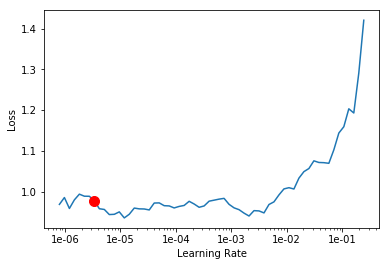

In [17]:
learn8.lr_find(start_lr=1e-7, end_lr=100)
learn8.recorder.plot(suggestion=True)

In [19]:
lr = learn8.recorder.min_grad_lr

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.915072,0.711462,0.581348,0.494129,15:09
1,0.873283,0.678160,0.611754,0.512092,15:09
2,0.827188,0.652460,0.633311,0.526501,15:11
3,0.832509,0.649819,0.634672,0.523663,15:11
4,0.828364,0.647719,0.636714,0.525653,15:11


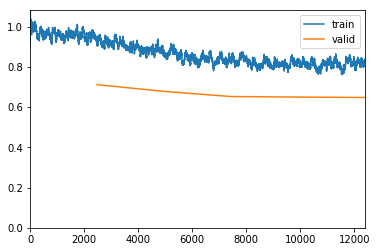

In [21]:
learn8.fit_one_cycle(5, slice(lr))

In [23]:
learn8.save('atelectasis-learn8-dn121')

In [25]:
learn8.unfreeze() # sets every layer group to trainable

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-06


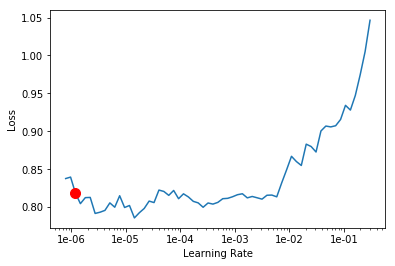

In [26]:
learn8.lr_find(start_lr=1e-7, end_lr=100)
learn8.recorder.plot(suggestion=True)

In [28]:
lr = (1e-6 + 1e-5) / 2
lr

5.500000000000001e-06

In [29]:
from fastai.callback import *


epoch,train_loss,valid_loss,accuracy,auc,time
0,0.825248,0.637489,0.643522,0.540375,19:57
1,0.779749,0.636631,0.640799,0.538484,20:11
2,0.770270,0.634552,0.649875,0.542528,20:11


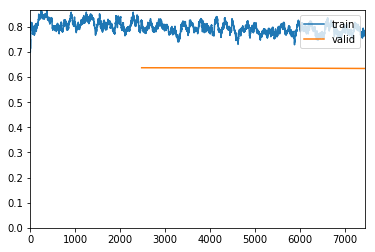

In [31]:
learn8.fit_one_cycle(3, slice(lr, lr/5))

In [32]:
learn8.save('atelectasis-learn8-dn121')